In [1]:
%matplotlib notebook

In [2]:
from IPython.display import display, HTML
display(HTML('<style>.container { width:90% !important; }</style>'))

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist
from sklearn.linear_model import LinearRegression
from pyEDM import *

# Figure 1: Cross-Mapping

In [6]:
data = pd.read_csv('high_resolution_five_species_model_data.csv', index_col=0)
data = (data - data.min()) / (data.max() - data.min()) # Min-max normalize data

def get_block(data, num_lags=4, tau=1):
    ''' Get a dataframe with all the possible valid lags of the variables. '''
    
    backward_lags = pd.concat([data[var].shift(lag*tau).rename(f'{var}(t-{lag*tau})') for lag in range(num_lags+1) for var in data.columns], axis=1)
    forward_lags  = pd.concat([data[var].shift(-1*lag*tau).rename(f'{var}(t+{lag*tau})') for lag in range(1,num_lags+1) for var in data.columns], axis=1)
    block = pd.concat([backward_lags, forward_lags], axis=1)
    
    return block

block = get_block(data)

In [7]:
def get_excluded_indices_map(block, exclusion_radius):
    excluded_indices_map = {}
    idxs = block.index.tolist()
    min_idx = idxs[0]
    max_idx = idxs[len(idxs)-1]

    for idx in idxs:
        excluded_idxs = {idx}
        for j in range(1, exclusion_radius + 1):
            excluded_idxs.update({max(min_idx, idx - j), min(max_idx, idx + j)})
        excluded_indices_map[idx] = (min(excluded_idxs), max(excluded_idxs))
    return excluded_indices_map

In [8]:
def CrossMap_smap(block, target, embedding_cols, Tp, theta, exclusion_radius=0):
    
    # Create an E-dimensional attractor reconstruction using the embedding columns
    embedding = block[embedding_cols]
    
    # Precompute excluded indices for each index
    excluded_indices_map = get_excluded_indices_map(block, exclusion_radius)
    
    # Get distance matrix
    distance_matrix = pd.DataFrame(cdist(embedding, embedding), index=block.index)
    distance_matrix.columns = block.index
    
    # Find bad nearest neighbor indices for cross-mapping. Bad nns are nns where:
    # - target+Tp is NaN
    valid_target_idxs = block.index[block[target].notna().to_numpy().nonzero()[0]]
    all_lib_idxs = block.index
    target_nan_idxs = block.index[np.where(~np.isin(all_lib_idxs + Tp, valid_target_idxs))[0]]
    # - NaNs in the embedding vector (distances cannot be properly computed)
    nan_idxs = np.where(distance_matrix.isna().all(axis=1))
    nan_idx_names = distance_matrix.index[nan_idxs]
    bad_nns = sorted(set(target_nan_idxs.tolist() + nan_idx_names.tolist()))
    
    # Replace bad nearest neighbors in the distance matrix with NaNs
    distance_matrix.loc[:,bad_nns] = np.nan

    # Compute the mean distance for each row
    def row_mean(row):
        return np.nanmean(row) if np.sum(~np.isnan(row)) else np.nan
    mean_distances = np.apply_along_axis(row_mean, axis=1, arr=distance_matrix)
    
    # Compute the weight matrix. Weight is e^(θd/d‾), where d‾ is the average distance between points
    weight_matrix = np.exp((-theta * distance_matrix) / mean_distances[:,np.newaxis])
      
    # For each index, get an S-map cross-prediction of target(idx)+Tp
    predictions = np.empty(len(embedding))
    predictions.fill(np.nan)
    
    # Convert exclusion_indices_map to a list of tuples
    excluded_indices_list = [excluded_indices_map[idx] for idx in embedding.index]
    index_to_position = {name: pos for pos, name in enumerate(embedding.index)}
    excluded_indices_list = [(index_to_position[indices[0]], index_to_position[indices[1]]) for indices in excluded_indices_map.values()]
    
    shifted_target = block[target].shift(-Tp).to_numpy()
    weight_matrix_np = weight_matrix.to_numpy()
    embedding_np = embedding.to_numpy()
    
    for i, idx in enumerate(embedding.index):
        
        query_pt = embedding_np[i,:].reshape(1,-1)
        
        # Get the weights for the current index
        weights = weight_matrix_np[i,:].reshape(-1,1)
        
        # Combine the embedding, shifted target, and weights
        combined = np.hstack((embedding_np, shifted_target.reshape(-1,1), weights))
        
        # Apply exclusion radius by setting the weights to 0 for excluded indices
        excluded_indices = excluded_indices_list[i]
        combined[excluded_indices[0]:excluded_indices[1]+1,-1] = np.nan
        
        # Remove any nan rows from combined
        combined = combined[~np.isnan(combined).any(axis=1)]
        
        # Normalize remaining weights
        if np.sum(combined[:,-1]) != 0:
            combined[:,-1] = combined[:,-1] / np.sum(combined[:,-1])
        
        if len(combined) > 0:
            X = combined[:,:-2]
            y = combined[:,-2]
            sample_weights = combined[:,-1]
            
            # Fit the model
            model = LinearRegression()
            model.fit(X, y, sample_weight=sample_weights)

            # Predict the target+T for the given i
            pred_pt = model.predict(query_pt)[0]

        else:
            pred_pt = np.nan
            
        predictions[i] = pred_pt
        
    # Store the results, labeling out-of-sample predictions with 'os'
    cross_map_results = store_results(block, target, Tp, predictions)
    
    return cross_map_results

In [9]:
def store_results(block, target, Tp, predictions):
    
    results = pd.DataFrame(block[[target]])
    results.columns = ['Observations']
    results['Predictions'] = None
    
    ## Add out-of-sample rows to results dataframe if needed. Store predictions as dataframe with correct index
    all_pred_idxs = block.index
    all_indices_plus_Tp = [i + Tp for i in all_pred_idxs]
    indices_to_insert = [i for i in all_indices_plus_Tp if i not in all_pred_idxs]
    new_rows_df = pd.DataFrame(np.nan, index=indices_to_insert, columns=results.columns)
    
    if any(i< min(all_pred_idxs) for i in indices_to_insert):
        # Concatenate new rows of NaNs at the beginning
        indices_to_insert = ['os'+str(i) for i in range(-len(indices_to_insert),0)]
        new_index = indices_to_insert + results.index.tolist()
        results = pd.concat([new_rows_df, results])
        results = results.reindex(new_index)
        predictions_df = pd.DataFrame(predictions, index=new_index[:len(predictions)])

    elif any(i > max(all_pred_idxs) for i in indices_to_insert):
        # Concatenate new rows of NaNs at the end
        indices_to_insert = ['os'+str(i+1) for i in range(len(indices_to_insert))]
        new_index = results.index.tolist() + indices_to_insert
        results = pd.concat([results, new_rows_df])
        results = results.reindex(new_index)
        predictions_df = pd.DataFrame(predictions, index=new_index[-len(predictions):])

    else:
        predictions_df = pd.DataFrame(predictions, index=results.index.tolist())

    for idx in predictions_df.index:
        if idx in results.index:
            results.loc[idx,'Predictions'] = predictions_df.loc[idx,0]

    results = results.apply(pd.to_numeric, errors='coerce')
    
    return results

def get_nns(block, embedding_cols, target, Tp):
    '''Find E+1 nearest neighbor times to time t in the embedding.''' 
    
    # - Precompute excluded indices to each index t
    excluded_indices_map = get_excluded_indices_map(block, exclusion_radius=0)
    
    # - Get distance matrix
    distance_matrix = pd.DataFrame(cdist(embedding_cols, embedding_cols), index=block.index)
    distance_matrix.columns = block.index
    
    # - Get nearest neighbor indices to each index
    nn_indices = pd.DataFrame(np.argsort(distance_matrix, axis=1))
    position_to_idx_map = {i: distance_matrix.columns[i] for i in range(len(distance_matrix))}
    nn_indices = nn_indices.map(lambda idx: position_to_idx_map[idx])
    
    # Find bad nearest neighbor indices for cross-mapping. Bad nns are nns where:
    # - target+Tp is NaN
    valid_target_idxs = block.index[block[target].notna().to_numpy().nonzero()[0]]
    all_lib_idxs = block.index
    target_nan_idxs = block.index[np.where(~np.isin(all_lib_idxs + Tp, valid_target_idxs))[0]]
    # - NaNs in the embedding vector (distances cannot be properly computed)
    nan_idxs = np.where(distance_matrix.isna().all(axis=1))
    nan_idx_names = distance_matrix.index[nan_idxs]
    bad_nns = sorted(set(target_nan_idxs.tolist() + nan_idx_names.tolist()))

    # Replace bad_nns in the nn_indices dataframe with NaNs. Also replace any nns within the exclusion radius with NaNs.
    nn_indices.replace(bad_nns, np.nan, inplace=True)   
    
    def exclude_points(row, excluded_indices_map):
        for idx in range(excluded_indices_map[row.name][0], excluded_indices_map[row.name][1] + 1):
            row = row.replace(idx, np.nan)
        return row
    nn_indices = nn_indices.apply(exclude_points, args=(excluded_indices_map,), axis=1)
    nn_indices[f'nns'] = nn_indices.values.tolist()
    nn_indices[f'nns'] = [[int(nns) for nns in x if not np.isnan(nns)][:num_nns] for x in nn_indices[f'nns']]
    nn_indices = nn_indices[[f'nns']].copy()
    
    xmap_input = nn_indices[[f'nns']].copy()

    # Indices where there were any nans in the embedding should not have any nearest neighbors
    xmap_input.loc[nan_idx_names,f'nns'] = [[np.nan] * num_nns]
    
    # Get distances for the nns
    def get_distances(index, nns, distance_matrix):
        if pd.isna(nns).all():
            return [np.nan] * len(nns)
        return [distance_matrix.loc[index,nn] if not pd.isna(nn) else np.nan for nn in nns]
    xmap_input['distances'] = xmap_input.apply(lambda row: get_distances(row.name, row['nns'], distance_matrix), axis=1)
    
    # Get weights based on nearest neighbor distances (e^-dist)
    def compute_weights(distances):
        weights = np.exp(-np.array(distances))
        normalized_weights = weights / np.sum(weights)  # Normalize weights to sum to 1
        return normalized_weights.tolist()
    xmap_input['weights'] = xmap_input['distances'].apply(compute_weights)
    
    # Get target values at nns + Tp    
    xmap_input['nns+Tp'] = xmap_input['nns'].apply(lambda x: [i + Tp for i in x])
    index_to_target_map = dict(zip(block.index, block[target]))
    def map_nns_to_values(nns, index_to_target_map):
        return [index_to_target_map.get(nn, np.nan) for nn in nns]
    xmap_input['target(nns+Tp)'] = xmap_input['nns+Tp'].apply(map_nns_to_values, index_to_target_map=index_to_target_map)
    
    # Get cross-map values
    vals_to_avg = np.array(xmap_input['target(nns+Tp)'].tolist())
    weights = np.array(xmap_input['weights'].tolist())
    xmap_input['predictions'] = np.nansum(vals_to_avg * weights, axis=1)
    
    # Create mask so that any predictions made with incomplete embedding vectors are NaN
    nan_mask = np.all(np.isnan(vals_to_avg), axis=1)
    xmap_input.loc[nan_mask,'predictions'] = np.nan

    predictions = xmap_input['predictions'].values.tolist()
    
    # Store the results, labeling out-of-sample predictions with 'os'
    cross_map_results = store_results(block, target, Tp, predictions)
    
    return nn_indices, cross_map_results

In [10]:
def plot_embedding_simplex(ax, embedding, nnt, block, title, c='gray', s=5, a=0.4, l=-15):
    gray_dots = block.copy()
    gray_dots = gray_dots[~gray_dots.index.isin([t] + nnt)]
    
    ax.scatter(gray_dots[embedding[0]], gray_dots[embedding[1]], gray_dots[embedding[2]], c=c, s=s, alpha=a)
    ax.plot(block[embedding[0]].values, block[embedding[1]].values, block[embedding[2]].values, c=c, linewidth=0.5, alpha=a)
    ax.scatter(block.loc[t, embedding[0]], block.loc[t, embedding[1]], block.loc[t, embedding[2]], c='tab:red', s=s*2)
    for nnt_point in nnt:
        ax.scatter(block.loc[nnt_point, embedding[0]], block.loc[nnt_point, embedding[1]], block.loc[nnt_point, embedding[2]], c='deepskyblue', s=s)
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='system states', markerfacecolor=c, markersize=7),
                       plt.Line2D([0], [0], marker='o', color='w', label='t = '+str(t), markerfacecolor='tab:red', markersize=7),
                       plt.Line2D([0], [0], marker='o', color='w', label='t = '+', '.join(map(str, nnt)), markerfacecolor='deepskyblue', markersize=7)]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.3), fancybox=True, ncol=1)
    ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([])
    ax.set_xlabel(embedding[0], labelpad=l); ax.set_ylabel(embedding[1], labelpad=l); ax.set_zlabel(embedding[2], labelpad=l)
    
    # Customize grid lines in 3D plot
    ax.xaxis._axinfo['grid'].update(color='lightgrey', linestyle='-', linewidth=0.5)
    ax.yaxis._axinfo['grid'].update(color='lightgrey', linestyle='-', linewidth=0.5)
    ax.zaxis._axinfo['grid'].update(color='lightgrey', linestyle='-', linewidth=0.5)
    
    ax.set_title(title, y=1.4)

In [11]:
import matplotlib.colors as mcolors

def plot_embedding_smap(ax, embedding_cols, t, block, Tp, theta, title, c='gray', s=5, a=0.4, l=-15):

    embedding = block[embedding_cols]
    
    # Create a gray to red colormap
#     silver_rgb = mcolors.to_rgb('gray')
#     tab_red_rgb = (1,0,0)
#     colors = [silver_rgb, tab_red_rgb]  # Gray to Red
#     cmap_name = 'gray_red'
#     cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
    cm = 'plasma'

    # Plot the embedding and other data
    embedding = block[embedding_cols]
    weights = get_weights(block, embedding_cols, t, target, Tp, theta)
    gray_dots = block.copy()
    
    gray_dots = gray_dots[~gray_dots.index.isin([t])]
    weights = weights[~weights.index.isin([t])]
    weights = (weights / weights.sum())
    
    ax.scatter(gray_dots[embedding_cols[0]], gray_dots[embedding_cols[1]], gray_dots[embedding_cols[2]], c=weights, cmap=cm, s=s, zorder=2)
    ax.plot(block[embedding_cols[0]].values, block[embedding_cols[1]].values, block[embedding_cols[2]].values, c=c, linewidth=0.3, alpha=1)
    ax.scatter(block.loc[t, embedding_cols[0]], block.loc[t, embedding_cols[1]], block.loc[t, embedding_cols[2]], c='tab:red', s=s*2)
    ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([])
    ax.set_xlabel(embedding_cols[0], labelpad=l); ax.set_ylabel(embedding_cols[1], labelpad=l); ax.set_zlabel(embedding_cols[2], labelpad=l)

    # Legend for the plot
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='system states', markerfacecolor=c, markersize=7),
        plt.Line2D([0], [0], marker='o', color='w', label=f't = {t}', markerfacecolor='tab:red', markersize=7),
        plt.Line2D([0], [0], marker='o', color='w', label='weight', markerfacecolor='tab:red', markersize=7)
    ]
    legend = ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.3), fancybox=True, ncol=1)
    ax.set_title(f'Attractor Reconstruction 2 \n(Does Not Include {target[0]})', y=1.4)

    # Create ax_inside_legend
    fig = ax.get_figure()
    #ax_inside_legend = fig.add_axes([0.732, 0.787, 0.02, 0.05])  # [dist from left of figure to left of ax, ''bottom, width, weight]
    ax_inside_legend = fig.add_axes([0.732, 0.733, 0.02, 0.05])  # [dist from left of figure to left of ax, ''bottom, width, weight]
    colormap_array = np.linspace(0, 255, 256) / 255.0
    ax_inside_legend.imshow([colormap_array], cmap=cm, aspect=0.1, extent=[0.5, 0.6, 0.6, 0.2])  # [left, right, bottom, top]
    ax_inside_legend.axis('off')
    legend.legend_handles.append(ax_inside_legend)
    
    # Customize grid lines in 3D plot
    ax.xaxis._axinfo['grid'].update(color='lightgrey', linestyle='-', linewidth=0.5)
    ax.yaxis._axinfo['grid'].update(color='lightgrey', linestyle='-', linewidth=0.5)
    ax.zaxis._axinfo['grid'].update(color='lightgrey', linestyle='-', linewidth=0.5)

def get_weights(block, embedding_cols, t, target, Tp, theta):
    # Create an E-dimensional attractor reconstruction using the embedding columns
    embedding = block[embedding_cols]
    
    # Precompute excluded indices for each index
    excluded_indices_map = get_excluded_indices_map(block, exclusion_radius=0)
    
    # Get distance matrix
    distance_matrix = pd.DataFrame(cdist(embedding, embedding), index=block.index)
    distance_matrix.columns = block.index
    
    # Find bad nearest neighbor indices for cross-mapping. Bad nns are nns where:
    # - target+Tp is NaN
    valid_target_idxs = block.index[block[target].notna().to_numpy().nonzero()[0]]
    all_lib_idxs = block.index
    target_nan_idxs = block.index[np.where(~np.isin(all_lib_idxs + Tp, valid_target_idxs))[0]]
    # - NaNs in the embedding vector (distances cannot be properly computed)
    nan_idxs = np.where(distance_matrix.isna().all(axis=1))
    nan_idx_names = distance_matrix.index[nan_idxs]
    bad_nns = sorted(set(target_nan_idxs.tolist() + nan_idx_names.tolist()))
    
    # Replace bad nearest neighbors in the distance matrix with NaNs
    distance_matrix.loc[:,bad_nns] = np.nan

    # Compute the mean distance for each row
    def row_mean(row):
        return np.nanmean(row) if np.sum(~np.isnan(row)) else np.nan
    mean_distances = np.apply_along_axis(row_mean, axis=1, arr=distance_matrix)
    
    # Compute the weight matrix. Weight is e^(θd/d‾), where d‾ is the average distance between points
    weight_matrix = np.exp((-theta * distance_matrix) / mean_distances[:,np.newaxis])
    
    return weight_matrix.loc[:,t]

times where the two embeddings find the exact same nearest neighbors:
[8, 11, 12, 21, 34, 47, 61, 67, 68, 69, 72, 91, 93, 105, 113, 124, 135, 136, 140, 142, 150, 161, 163, 174, 191, 206, 213, 215, 221, 229, 230, 245, 246, 252, 257, 258, 259, 260, 265, 276]


<IPython.core.display.Javascript object>


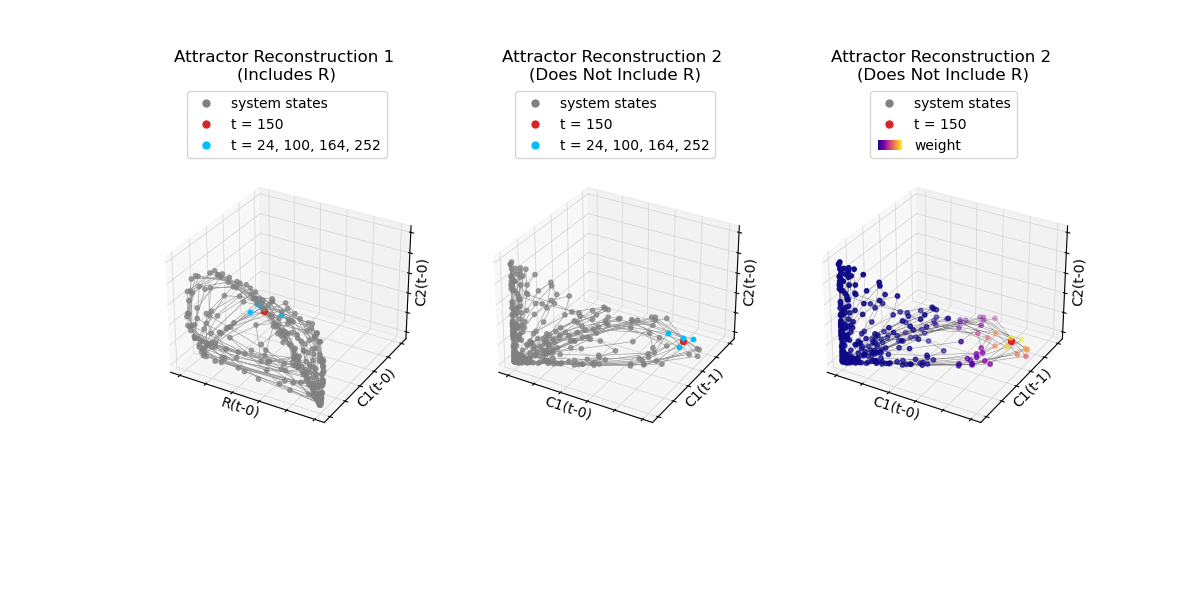

<IPython.core.display.Javascript object>


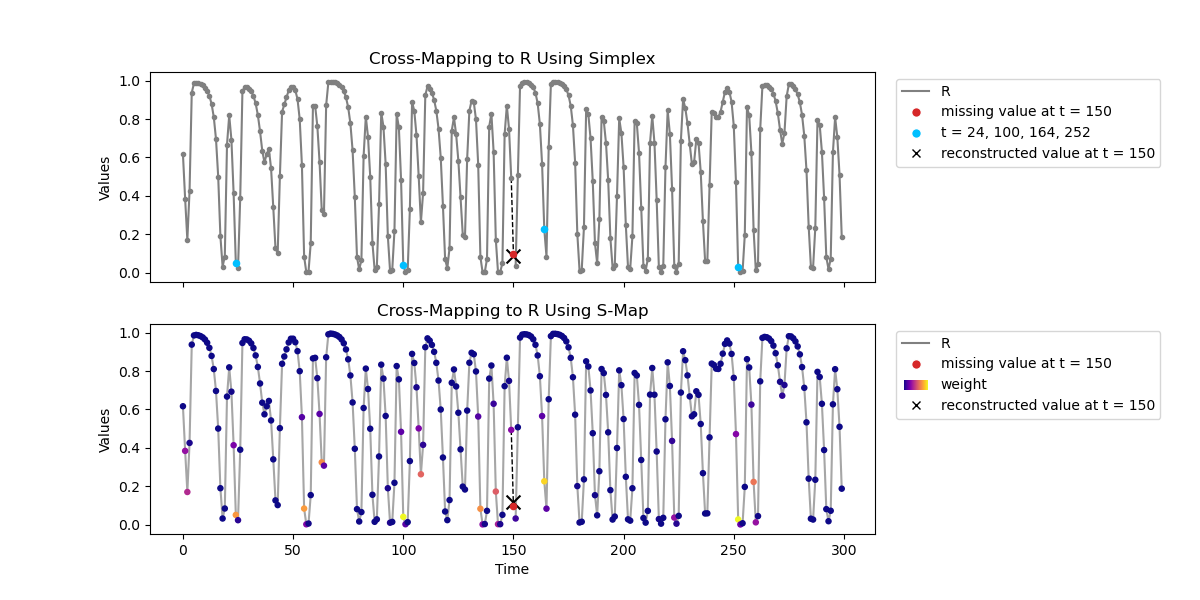

In [12]:
def make_figure_1(block, t, target, Tp, theta, num_nns, embedding_cols_1, embedding_cols_2):
    
    embedding_1 = block[embedding_cols_1]
    embedding_2 = block[embedding_cols_2]
    
    nns_1, xmap_simplex_1 = get_nns(block, embedding_1, target, Tp)
    nns_2, xmap_simplex_2 = get_nns(block, embedding_2, target, Tp)
    
    nns_comparison = pd.concat([nns_1, nns_2], axis=1)
    nns_comparison.columns = ['nns_1', 'nns_2']
    
    def compare_sorted_lists(row):
        return sorted(row['nns_1']) == sorted(row['nns_2'])
    
    # Find indices where the two embeddings find the same nearest neighbors
    same_nns = nns_comparison[nns_comparison.apply(compare_sorted_lists, axis=1)]
    
    print('times where the two embeddings find the exact same nearest neighbors:')
    print(same_nns.index.tolist())
    
    nnt_1 = sorted(nns_1.loc[t].item())
    nnt_2 = sorted(nns_2.loc[t].item())
    
    # Make first row of figure - 3d plots of embeddings
    fig = plt.figure(figsize=(12,6)); gs = gridspec.GridSpec(1,3, width_ratios = [1,1,1])
    ax0 = plt.subplot(gs[0, 0], projection='3d'); ax1 = plt.subplot(gs[0, 1], projection='3d'); ax2 = plt.subplot(gs[0, 2], projection='3d'); 

    # Plot embeddings
    s = 10; '''s = dot size'''; a = 0.7; '''a = dot transparency'''
    plot_embedding_simplex(ax0, embedding_cols_1, nnt_1, block, s=s, a=a, title=f'Attractor Reconstruction 1 \n(Includes {target[0]})')
    plot_embedding_simplex(ax1, embedding_cols_2, nnt_2, block, s=s, a=a, title=f'Attractor Reconstruction 2 \n(Does Not Include {target[0]})')  
    plot_embedding_smap(ax2, embedding_cols_2, t, block, Tp, theta, s=s, a=a, title=f'Attractor Reconstruction 2 \n(Does Not Include {target[0]})')
    
    ######### Make second row of figure - cross-mapping demonstration
    
    fig = plt.figure(figsize=(12,6)); gs = gridspec.GridSpec(2,2, height_ratios=[1,1], width_ratios=[6,1])
    ax3 = plt.subplot(gs[0]); ax4 = plt.subplot(gs[2])
    
    gap_target = block[[target]].copy()
    gap_target.loc[t,target] = np.nan

    # Plot cross-mapping with Simplex
    c = 'gray'; s = 20
    cross_mapped_value = xmap_simplex_1.loc[t,'Predictions']
    block[t-1:t+1].plot(y=target, ax=ax3, c='k', style='--', linewidth=1)
    gap_target.plot(y=target, ax=ax3, c=c, alpha=1, style='.-')
    ax3.scatter([nnt_2[0], nnt_2[1], nnt_2[2], nnt_2[3]], block[block.index.isin(nnt_2)][target], c='deepskyblue', zorder=4, s=s)
    ax3.scatter(t, cross_mapped_value, c='k', marker='x', zorder=5, s=100)
    ax3.scatter(t, block.loc[t, target], c='tab:red', zorder=5, s=s)
    legend_elements = [plt.Line2D([0], [0], color=c, label=target[0]),
                       plt.Line2D([0], [0], marker='o', color='w', label='missing value at t = '+str(t), markerfacecolor='tab:red', markersize=7),
                       plt.Line2D([0], [0], marker='o', color='w', label='t = '+str(nnt_2[0])+', '+str(nnt_2[1])+', '+str(nnt_2[2])+', '+str(nnt_2[3]), markerfacecolor='deepskyblue', markersize=7),
                       plt.Line2D([0], [0], marker='x', color='k', label='reconstructed value at t = '+str(t), linestyle='')]
    legend = ax3.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02,1))
    ax3.set_xticklabels([]); ax3.set_xlabel('')
    ax3.set_ylabel('Values')
    ax3.set_title('Cross-Mapping to R Using Simplex')

    cm = 'plasma'
    
#     # Plot cross-mapping with S-map
    gray_dots = block.copy(); gray_dots = gray_dots[~gray_dots.index.isin([t])]
    weights = get_weights(block, embedding_cols_2, t, target, Tp, theta); weights = weights[~weights.index.isin([t])]; weights = (weights / weights.sum())
    weights = np.array(weights).reshape(-1); weights = np.nan_to_num(weights, nan=0.0)
    xmap_smap = CrossMap_smap(block, target, embedding_cols_2, Tp, theta)
    cross_mapped_value = xmap_smap.loc[t,'Predictions']
    block[t-1:t+1].plot(y=target, ax=ax4, c='k', style='--', linewidth=1)
    gap_target.plot(y=target, ax=ax4, c=c, alpha=0.7)
    ax4.scatter(gray_dots.index, gray_dots[target].values, c=weights.tolist(), cmap=cm, zorder=2, s=s/1.5)
    ax4.scatter(t, block.loc[t, target], c='tab:red', zorder=5, s=s)
    ax4.scatter(t, cross_mapped_value, c='k', marker='x', zorder=4, s=100)
    legend_elements = [plt.Line2D([0], [0], color=c, label=target[0]),
                       plt.Line2D([0], [0], marker='o', color='w', label='missing value at t = '+str(t), markerfacecolor='tab:red', markersize=7),
                       plt.Line2D([0], [0], marker='o', color='w', label='weight', markerfacecolor='deepskyblue', markersize=7),
                       plt.Line2D([0], [0], marker='x', color='k', label='reconstructed value at t = '+str(t), linestyle='')]
    legend = ax4.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02,1))
    ax4.set_title('Cross-Mapping to R Using S-Map')
    ax4.set_xlabel('Time')
    ax4.set_ylabel('Values')

    ax_inside_legend = fig.add_axes([0.753, 0.333, 0.02, 0.05]) # [dist from left of figure to left of ax, ''bottom, width, weight]
    colormap_array = np.linspace(0,255,256)/255.0
    ax_inside_legend.imshow([colormap_array], cmap=cm, aspect=0.1, extent=[0.5,0.6,0.6,0.2]) # [left, right, bottom, top]
    ax_inside_legend.axis('off')
    legend.legend_handles.append(ax_inside_legend)
    
    plt.show()
    
t           = 150
target      = 'R(t-0)'
theta       = 4
Tp          = 0
num_nns     = 4
embedding_1 = ['R(t-0)', 'C1(t-0)', 'C2(t-0)']
embedding_2 = ['C1(t-0)', 'C1(t-1)', 'C2(t-0)']

data_subset = data[228:528].reset_index(drop=True)
block_subset = get_block(data_subset)
make_figure_1(block_subset, t, target, Tp, theta, num_nns, embedding_1, embedding_2)